In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sys

In [53]:
class PDB_NERDSS():
    
    def __init__(self, parentDir='', pdbWrite=1e5):
        self._pdir = parentDir
        self._pdbStep = pdbWrite
        self.t = []
        self.x = []
        self.r = []
        self.proteinNumbers = []
        self.left = []
        self.right = []
        self.t_longest = []
        self.x_all = []
        self.x_onDNA = []
    
    def read_pdbs(self, N_repeat=None, pdbMin=0, pdbMax=np.inf, YZcenter=31.623/2, timeStep:float=1e-6):
        '''Read pdbs untill pdbMax
        
        Args:
        
            N_repeat (int, iterable): 
                (int) the number of repeats, will read subfolders named in `range(N_repeat)`
                (iterable of strings) the names of subfolders
            
            pdbMin (int): The min index (number of steps) of pdb read.
            
            pdbMax (int): The max index (number of steps) of pdb read.
            
            YZcenter (float): The center coordinate of Y and Z axes (they are the same) used to calculate r.
            
            timeStep (float): time jump for one step.
            
        Returns:
            None: 
                self.x (list of lists): x coordinates
                self.r (list of lists): r distances
                self.t (list of lists): time points
                self.t_longest (list): the longest time points
        '''
        
        self._pdbMax = pdbMax
        self._YZcenter = YZcenter
        self._tStep = timeStep
        
        if N_repeat is None:
            self._subnames = ['']
        elif isinstance(N_repeat, int):
            self._subnames = [str(i) for i in range(N_repeat)]
        else: # assume it is iterable
            self._subnames = [str(i) for i in N_repeat]
        self._Nrepeats = len(self._subnames)
        
        for subname in self._subnames:
            x = []
            r = []
            t = []
            NItr = pdbMin # include the initial coordinates
            while NItr < self._pdbMax:
                # in case the simulation does not run through pdbMax*pdbStep
                filename = int(NItr*self._pdbStep)
                x_itr = []
                r_itr = []
                try:
                    with open(f'{self._pdir}/{subname}/PDB/{filename}.pdb') as f:
                        for line in f:
                            if line.strip() == 'END':
                                pass
                            else:
                                linelist = line.split()
                                if linelist[2] == 'COM' and linelist[3] == 'P':
                                    x_itr.append(float(linelist[5]))
                                    CRDy = float(linelist[6])
                                    CRDz = float(linelist[7])
                                    r_itr.append(
                                        ((CRDy-self._YZcenter)**2 + (CRDz-self._YZcenter)**2)**0.5
                                    )
                    t.append(NItr*self._pdbStep*self._tStep)
                    NItr += 1
                except FileNotFoundError as e:
                    break
                
                x.append(x_itr)
                r.append(r_itr)
            self.x.append(x)
            self.r.append(r)
            self.t.append(t)
        
        self._subnames = [name for i, name in enumerate(self._subnames) if len(self.t[i]) != 0]
        self._Nrepeats = len(self._subnames)
        self.x = [x for i, x in enumerate(self.x) if len(self.t[i]) != 0]
        self.r = [r for i, r in enumerate(self.r) if len(self.t[i]) != 0]
        self.t = [t for t in self.t if len(t)!=0]
                
        
        self.t_longest = self.t[0]
        for t in self.t:
            if len(t) > len(self.t_longest):
                self.t_longest = t
        self.left = np.zeros_like(self.t_longest)
        self.right = np.zeros_like(self.t_longest)
    
    def classify_proteins(self, burnInSteps=1, windowMax=10, chromRadius=5.5, Xcenter=64/2):
        '''Classify proteins into different regions
        
        Args:
            burnInSteps (int): The min number of pdbs considered. Use this to exclude burn-in steps.
            
            windowMax (int): 
                The max window size used for calculating avarages. 
                There should be windowMax >= burnInSteps, otherwise windowMax = burnInSteps
            
            chromRadius (float): 
                The radius of chromatin. When r < chromRadius, this protein is considered as lying on DNA.
                Set this to np.inf to count all proteins in solution.
            
            Xcenter (float): The center of X axis. 
            
        Returns:
            None: 
                self.left (1darray): the probabilities of proteins in left
                self.right (1darray): the probabilities of proteins in right
                They are normalized to the total number of proteins.
        '''
        
        self._pdbNumMin = burnInSteps
        self._windowMax = max(windowMax, burnInSteps)
        self._chromR = chromRadius
        self._Xcenter = Xcenter
        
        left = []
        right = []
        self._copies = np.zeros_like(self.t_longest)
        for nr in range(self._Nrepeats):
            xn = np.array(self.x[nr])
            rn = np.array(self.r[nr])
            leftn = np.zeros(xn.shape[0])
            rightn = np.zeros(xn.shape[0])
            numPs = xn.shape[1]
            if numPs == 0:
                pass
            else:
                for ip in range(numPs):
                    leftn[ (xn[:,ip] < Xcenter) & (rn[:,ip] < chromRadius) ] += 1
                    rightn[ (xn[:,ip] > Xcenter) & (rn[:,ip] < chromRadius) ] += 1
                leftn[:self._pdbNumMin] = leftn[self._pdbNumMin]
                rightn[:self._pdbNumMin] = rightn[self._pdbNumMin]
                # now, left and right are the probabilities at the relavant timepoint
                left.append(leftn/numPs)
                right.append(rightn/numPs)
        
        for NItr in range(0, len(self.t_longest)):
            leftNItr = [ np.mean(left[nr][max(0,NItr-self._windowMax+1) : NItr+1]) for nr in range(self._Nrepeats) ]
            rightNItr = [ np.mean(right[nr][max(0,NItr-self._windowMax+1) : NItr+1]) for nr in range(self._Nrepeats) ]
#             print(leftNItr)
            self.left[NItr] = np.mean(leftNItr)
            self.right[NItr] = np.mean(rightNItr)

    def find_proteins_on_DNA(self, burnInSteps=0, chromRadius=5.5):
        '''Find proteins that are close to DNA
        
        Args:
            burnInSteps (int): The min number of pdbs considered. Use this to exclude burn-in steps.
            
            chromRadius (float): 
                The radius of chromatin. When r < chromRadius, this protein is considered as lying on DNA.
                Set this to np.inf to count all proteins in solution.
            
        Returns:
            None: 
                self.x_onDNA (1darray): the x coordinates of proteins on DNA
                self.totNumProtein (int): the total number of proteins
        '''
        
        self._pdbNumMin = burnInSteps
        self._chromR = chromRadius
        
        self.x_onDNA = []
        self.totNumProtein = 0
        
        for nr in range(0, self._Nrepeats):
            r_nr = np.array(self.r[nr])
            x_nr = np.array(self.x[nr])
            numPs = x_nr.shape[1]
            for ip in range(numPs):
                x_nr_ip = x_nr[self._pdbNumMin:, ip]
                r_nr_ip = r_nr[self._pdbNumMin:, ip]
                self.x_onDNA += [x for x in x_nr_ip[r_nr_ip <= self._chromR]]
                self.totNumProtein += len(x_nr_ip)
            
    def get_all_x(self, burnInSteps=1):
        '''collect all x coordinates of proteins
        
        Args:
            burnInSteps (int): The min number of pdbs considered. Use this to exclude burn-in steps.
            
        Returns:
            self.x_all (list): The x coordinates of proteins
        '''
        
        self._pdbNumMin = burnInSteps
        self.x_all = []
        
        for nr in range(0, self._Nrepeats):
            self.x_all += [x for x in self.x[nr][self._pdbNumMin:]]
        
        return self.x_all
        

In [54]:
def plothist(data, binEdges, normalization, color, ax, style='stairs'):
    hist, bin_edges = np.histogram(data, bins=binEdges, density=False)
    if style=='stairs':
        ax.stairs(hist/normalization, bin_edges, fill=True, color=color)
    elif style=='curve':
        ax.plot((bin_edges[1:]+bin_edges[:-1])/2, hist/normalization, color=color)
        

In [86]:
simdir = 'model/nerdss_output/'
burnIn = 0
simulations = PDB_NERDSS(f'./{simdir}/', 1e6)
simulations.read_pdbs(N_repeat=[n for n in range(1,31)], pdbMin=10, YZcenter=40/2)
simulations.find_proteins_on_DNA(burnIn, chromRadius=1+1e-6)

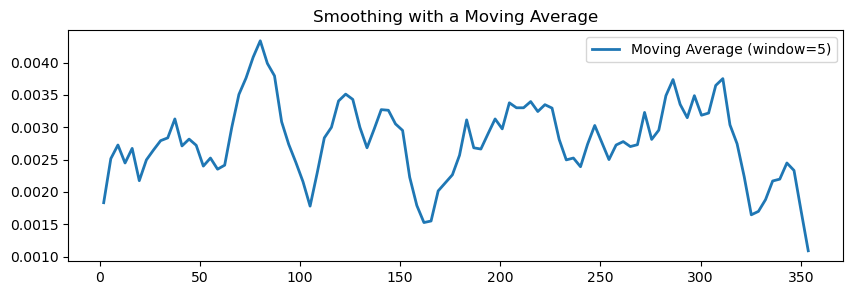

In [89]:
# 2. Get the histogram data (the values you are currently plotting)
# This gives us the y-values (counts/density) and the x-values (bin edges)
y_values, bin_edges = np.histogram(simulations.x_onDNA, bins=100, density=True)
# Calculate bin centers for a cleaner x-axis
x_values = (bin_edges[:-1] + bin_edges[1:]) / 2

# 1. Define the window size (must be an odd number)
# A larger window size results in a smoother curve.
window_size = 5

# 2. Calculate the moving average using convolution
# 'same' mode ensures the output array has the same length as the input
y_smooth_ma = np.convolve(y_values, np.ones(window_size)/window_size, mode='same')

# Plotting the result
plt.figure(figsize=(10, 3))
# plt.plot(x_values, y_values, alpha=0.3, label='Original Data') # Original
plt.plot(x_values, y_smooth_ma, lw=2, label=f'Moving Average (window={window_size})') # Smoothed
plt.title('Smoothing with a Moving Average')
plt.legend()
plt.show()

1. Random-binding dissociation有可能太快了，这种情况下只有正好bind在target上才会被记录下来，因此，看到的peak非常尖锐。
2. Binding affinity的假设不合理，protein过多停留在resemble trap上面，于是看到各处都有binding。最终目标是得到类似下图的分布：

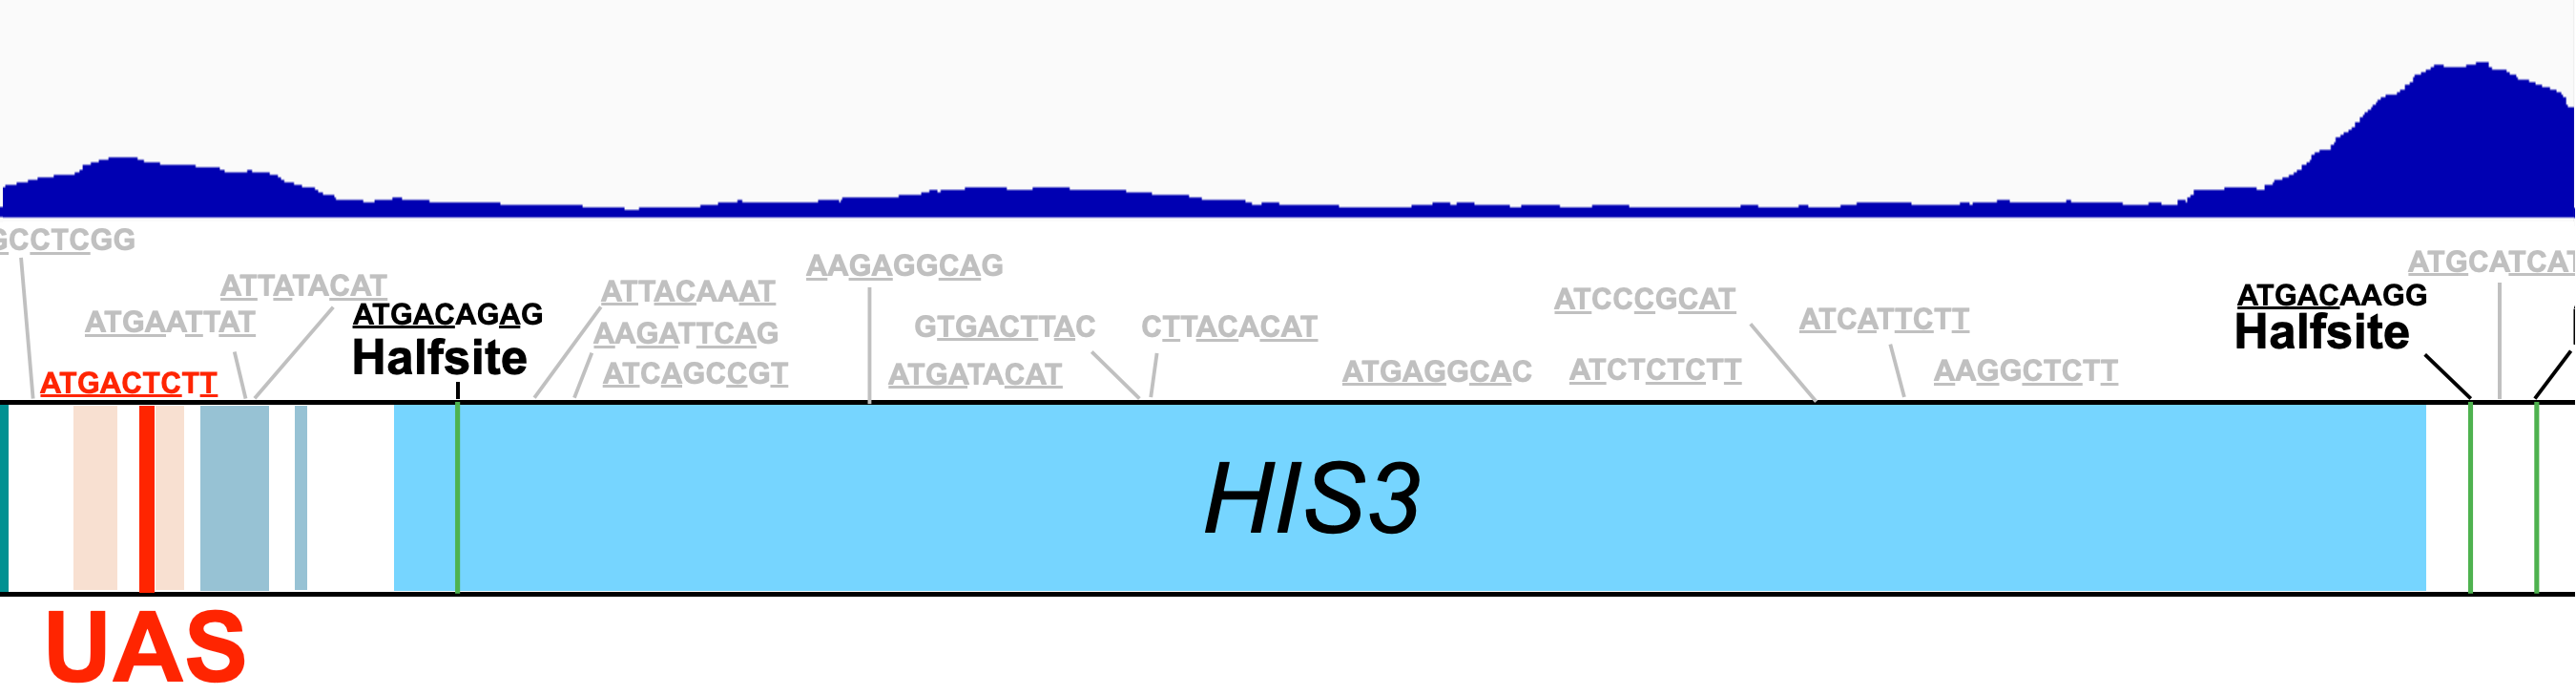

先kill当前的模拟，然后在rockfish上更换一个较小的kbN再进行模拟。留出来wile的算力可以validate 1D model。此外，在模拟中发现warning：`'result' does not fulfill the request.` Firstly, this warning is meaningless, and should be improved. It seems there are bonds selected multiple times in one dissociation step. Try a smaller kbN can generally reduce this problem.